In [1]:
import numpy as np
import pandas as pd
from scipy.ndimage import filters
import tensorflow as tf
from tensorboard.plugins import projector
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import recon
import encoder

In [2]:
np.random.seed(31415926)

In [3]:
path = os.path.join('..', '..', 'data', 'xiaoxue', 'csv')
data = recon.clean(pd.concat([recon.load(os.path.join(path, 'middle_chinese.csv')), recon.load(os.path.join(path, 'xiangyu.csv'))], axis=1))

In [4]:
initials = [c for c in data.columns if c.endswith('聲母')]
finals = [c for c in data.columns if c.endswith('韻母')]
tones = [c for c in data.columns if c.endswith('調值')]
columns = initials + finals + tones

data.dropna(how='all', subset=columns, inplace=True)
for c in columns:
    data[c] = data[c].astype('category')

categories = [data[c].cat.categories for c in columns]
limits = np.cumsum([0] + [len(c) for c in categories])
bases = limits[:-1]

codes = np.empty(data[columns].shape, dtype=np.int32)
for i, c in enumerate(columns):
    codes[:, i] = data[c].cat.codes

codes = pd.DataFrame(columns=columns, data=np.where(codes >= 0, codes + bases, -1))

In [5]:
initial_categories = [t.categories for t in data.dtypes[initials]]
final_categories = [t.categories for t in data.dtypes[finals]]
tone_categories = [t.categories for t in data.dtypes[tones]]
categories = initial_categories + final_categories + tone_categories

In [6]:
dataset = tf.data.Dataset.from_tensor_slices(codes.values).shuffle(1000).batch(100)

In [7]:
emb_size = 10
dae = encoder.DenoisingAutoEncoder([len(c) for c in categories], emb_size)
optimizer = tf.optimizers.Adam()

output_prefix = os.path.join(
    'tensorboard',
    '{}'.format(datetime.datetime.now().strftime('%Y%m%d%H%M'))
)

log_dir = output_prefix
summary_writer = tf.summary.create_file_writer(log_dir)

loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)
acc = tf.keras.metrics.Accuracy('acc', dtype=tf.float32)
eval_loss = tf.keras.metrics.Mean('eval_loss', dtype=tf.float32)
eval_acc = tf.keras.metrics.Accuracy('eval_acc', dtype=tf.float32)

checkpoint = tf.train.Checkpoint(embedding=dae.embedding, optimizer=optimizer)
manager = tf.train.CheckpointManager(checkpoint, os.path.join(output_prefix, 'checkpoints'), max_to_keep=10)

for epoch in range(200):
    for targets in dataset:
        inputs = tf.where(tf.random.uniform(targets.shape) < 0.5, targets, tf.cast(tf.fill(targets.shape, -1), targets.dtype))
        inputs = tf.reshape(inputs, (inputs.shape[0], 3, -1))
        loss(dae.update(inputs, targets, optimizer))
        acc.update_state(targets, dae.predict(inputs), tf.cast(targets >= 0, tf.float32))

    inputs = tf.reshape(codes.values, (codes.values.shape[0], 3, -1))
    targets = codes.values
    eval_loss(dae.loss(inputs, targets))
    eval_acc.update_state(targets, dae.predict(inputs), tf.cast(targets >= 0, tf.float32))
    
    with summary_writer.as_default():
            tf.summary.scalar('loss', loss.result(), step=epoch)
            tf.summary.scalar('acc', acc.result(), step=epoch)
            tf.summary.scalar('eval_loss', eval_loss.result(), step=epoch)
            tf.summary.scalar('eval_acc', eval_acc.result(), step=epoch)
            
    loss.reset_states()
    acc.reset_states()
    eval_loss.reset_states()
    eval_acc.reset_states()

    manager.save()

c:\users\yihuahuang\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\framework\indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/StatefulPartitionedCall_grad/PartitionedCall:1", shape=(None,), dtype=int32), values=Tensor("gradients/StatefulPartitionedCall_grad/PartitionedCall:0", shape=(None, 10), dtype=float32), dense_shape=Tensor("gradients/StatefulPartitionedCall_grad/PartitionedCall:2", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


In [8]:
initial_emb = dae.encode(codes[initials].values[:, None, :]).numpy()
final_emb = dae.encode(codes[finals].values[:, None, :]).numpy()
tone_emb = dae.encode(codes[tones].values[:, None, :]).numpy()

In [9]:
plt.rcParams.update({
    'font.family': 'serif',
    'mathtext.fontset': 'dejavusans',
    'font.serif': ['simsun', 'AR PL UMing CN'],
    'axes.unicode_minus': False,
})

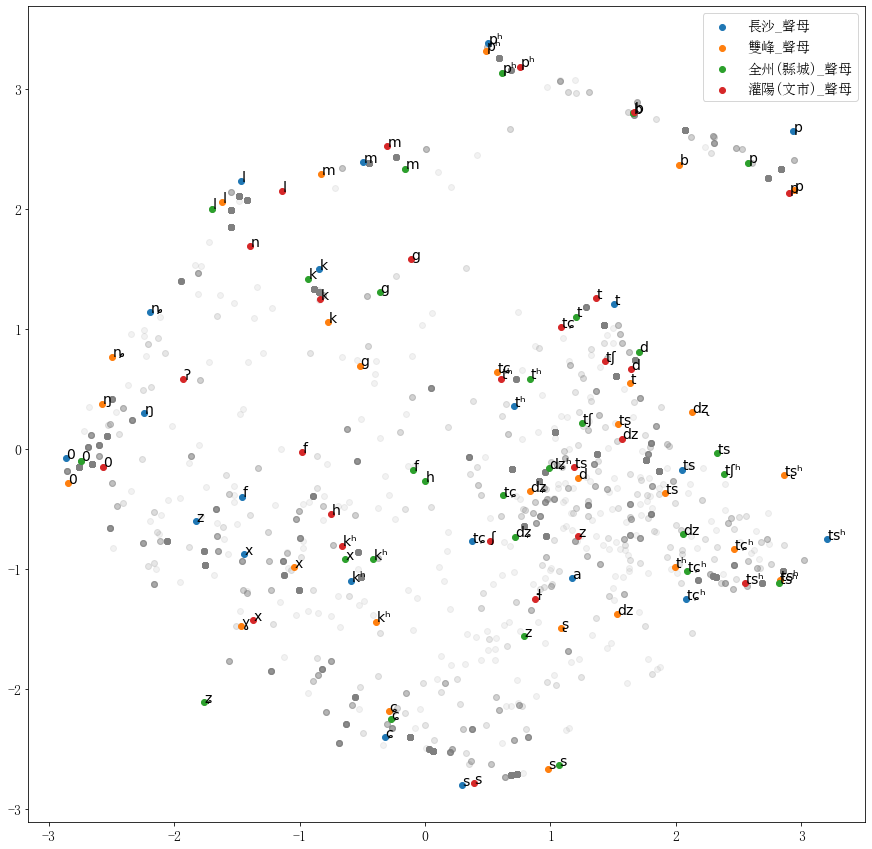

In [10]:
pca = PCA(2)

pc = pca.fit_transform(initial_emb)
emb_pc = pca.transform(dae.embedding.numpy())
out_emb_pc = pca.transform(dae.output_embedding.numpy())

plt.rcParams['font.size'] = 14
fig = plt.figure(figsize=(15, 15))

plt.scatter(pc[:, 0], pc[:, 1], color='gray', alpha=0.1)

for i, col in enumerate(initials):
    plt.scatter(emb_pc[limits[i]:limits[i + 1], 0], emb_pc[limits[i]:limits[i + 1], 1], label=col)
    for j, c in enumerate(initial_categories[i]):
        plt.annotate(r'$\mathrm{{{}}}$'.format(c), xy=(emb_pc[bases[i] + j, 0], emb_pc[bases[i] + j, 1]))
        
    continue
    plt.scatter(out_emb_pc[limits[i]:limits[i + 1], 0], out_emb_pc[limits[i]:limits[i + 1], 1], marker='^', label=col)
    for j, c in enumerate(initial_categories[i]):
        plt.annotate(r'$\mathrm{{{}}}$'.format(c), xy=(out_emb_pc[bases[i] + j, 0], out_emb_pc[bases[i] + j, 1]))

plt.legend()

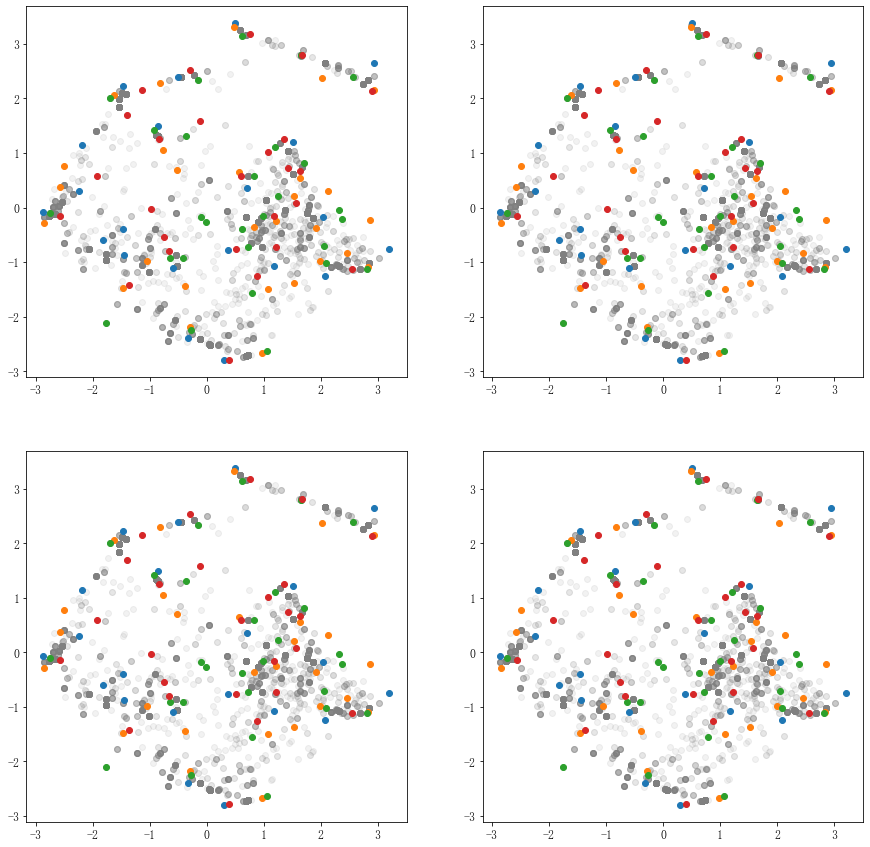

In [11]:
plt.rcParams['font.size'] = 12

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))
axes = (ax1, ax2, ax3, ax4)

for i in range(4):
    pca = PCA(2)
    pc = pca.fit_transform(initial_emb)
    emb_pc = pca.transform(dae.embedding.numpy())
    axes[i].scatter(pc[:, 0], pc[:, 1], color='gray', alpha=0.1)

    for j, col in enumerate(initials):
        axes[i].scatter(emb_pc[limits[j]:limits[j + 1], 0], emb_pc[limits[j]:limits[j + 1], 1], label=col)

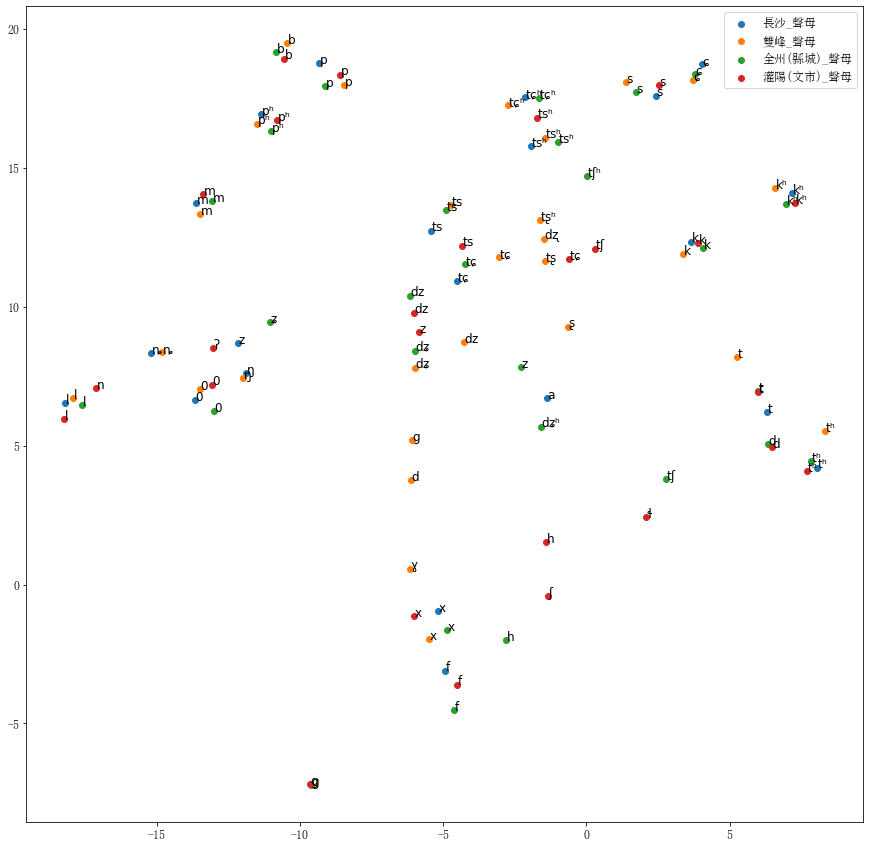

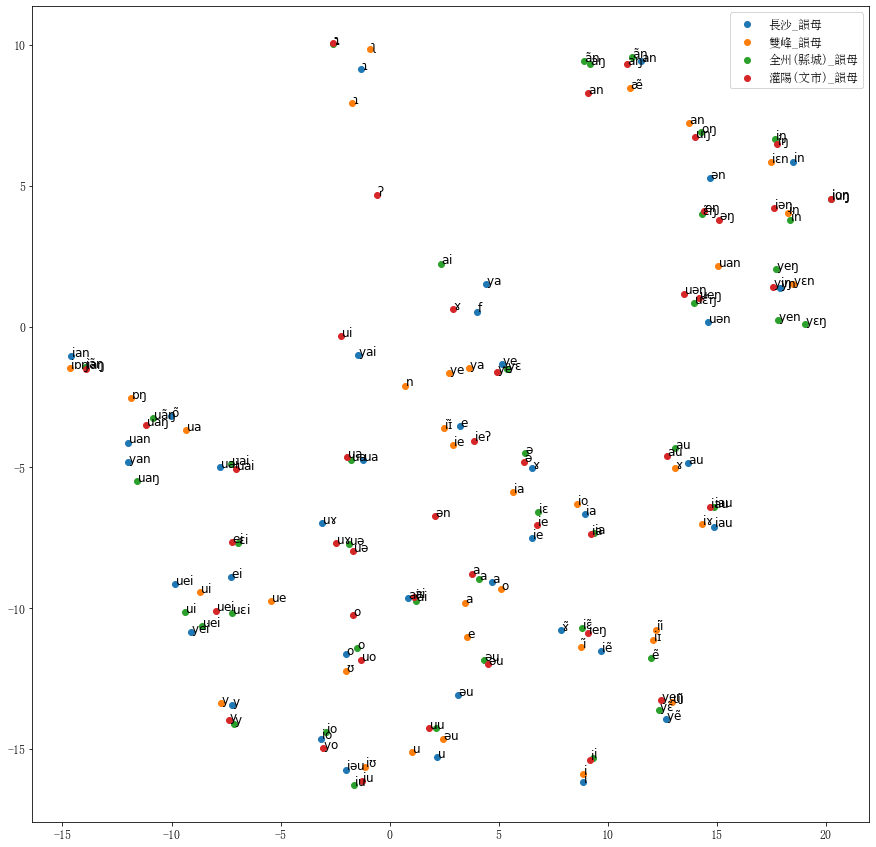

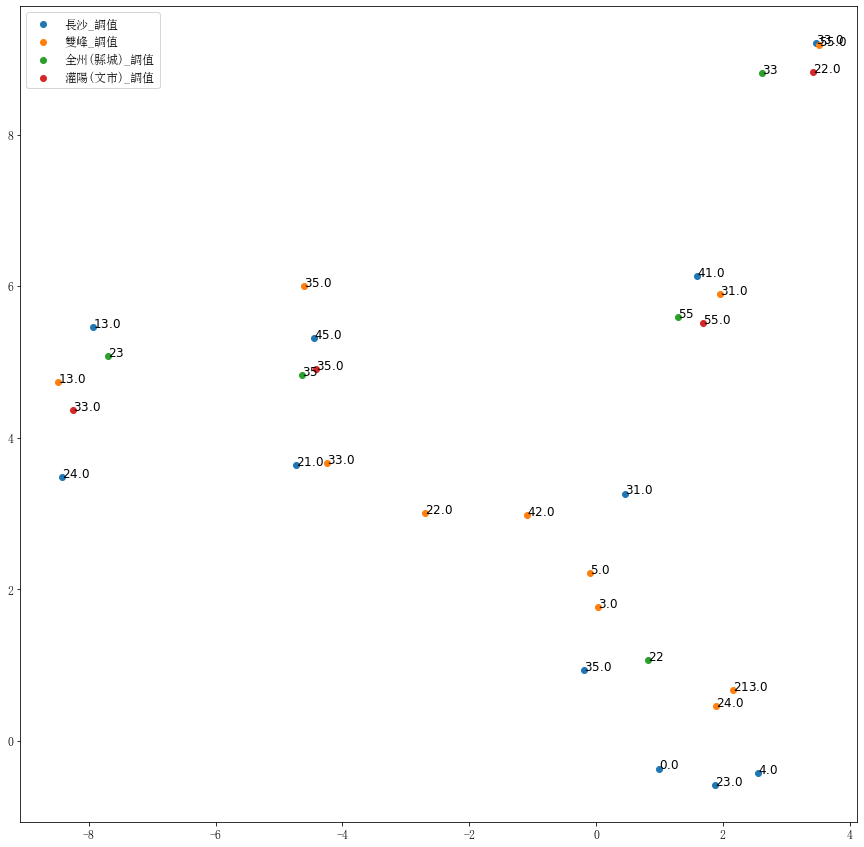

In [12]:
emb_tsne = TSNE(2).fit_transform(dae.embedding.numpy())

plt.rcParams['font.size'] = 12

for i, cols in enumerate((initials, finals, tones)):
    fig = plt.figure(figsize=(15, 15))

    for j, col in enumerate(cols):
        plt.scatter(emb_tsne[limits[i * 4 + j]:limits[i * 4 + j + 1], 0], emb_tsne[limits[i * 4 + j]:limits[i * 4 + j + 1], 1], label=col)
        for k, c in enumerate(data[col].cat.categories):
            plt.annotate(r'$\mathrm{{{}}}$'.format(c), xy=(emb_tsne[bases[i * 4 + j] + k, 0], emb_tsne[bases[i * 4 + j] + k, 1]))
    
    plt.legend()

<ipython-input-13-441df036f154>:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-13-441df036f154>:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-13-441df036f154>:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


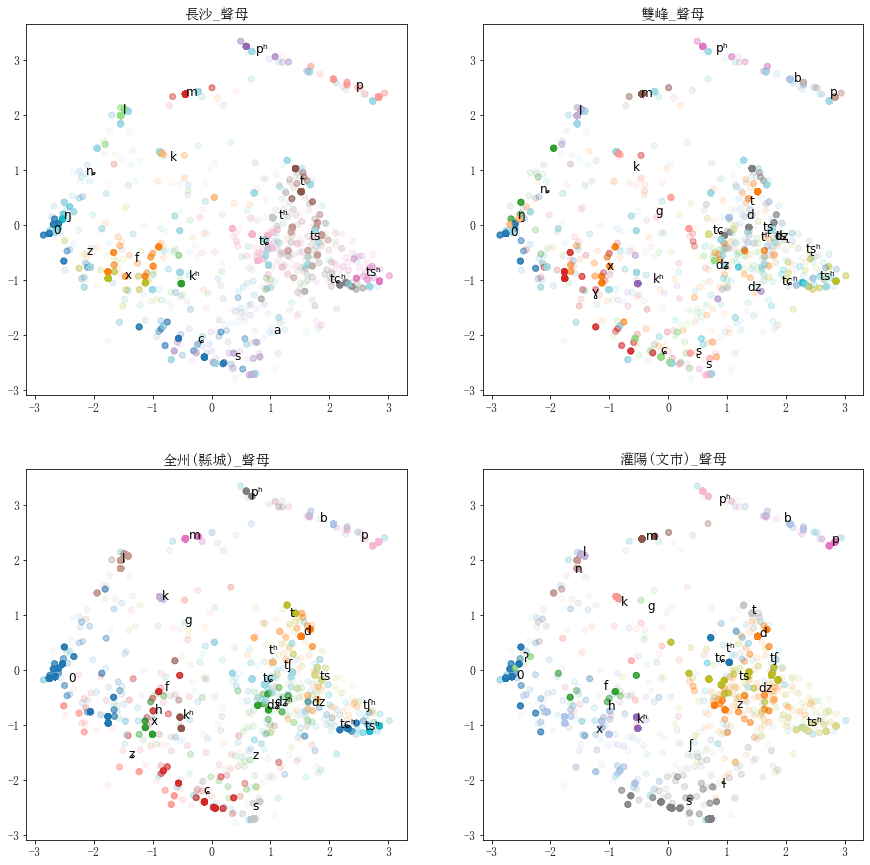

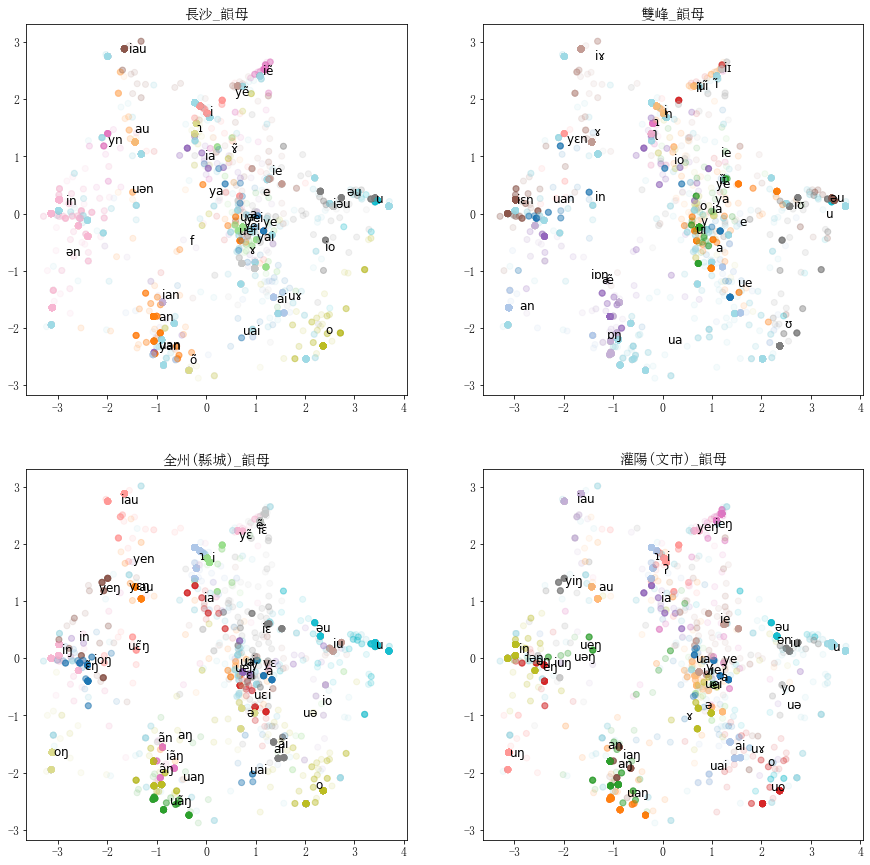

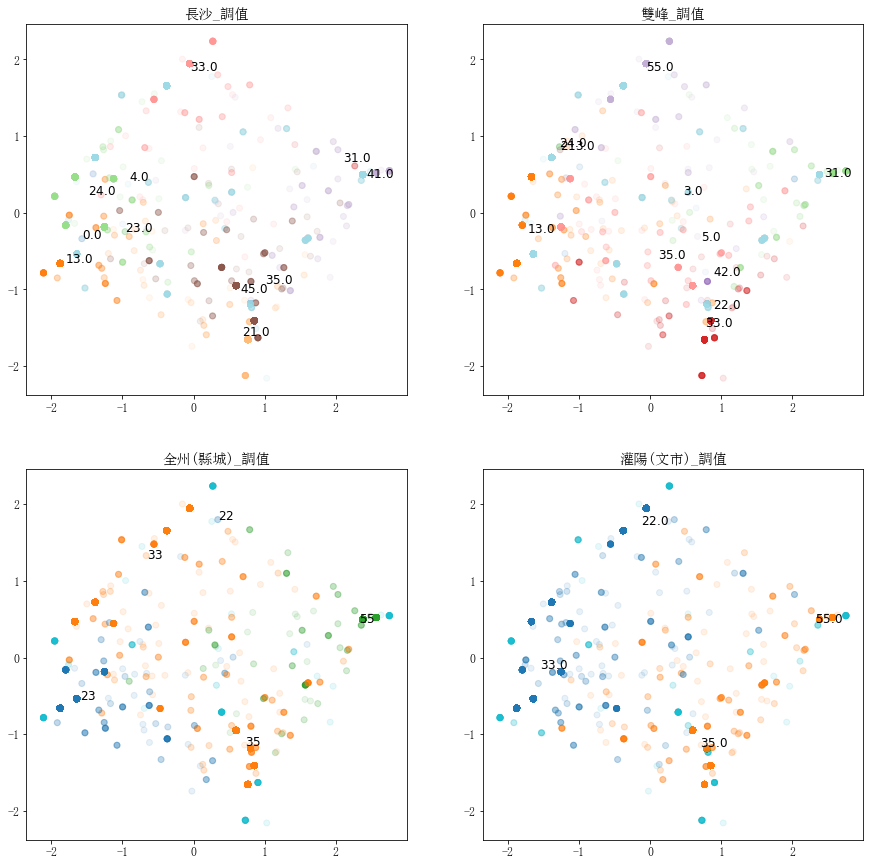

In [13]:
plt.rcParams['font.size'] = 12

for cols, emb in ((initials, initial_emb), (finals, final_emb), (tones, tone_emb)):
    pc = PCA(2).fit_transform(emb)

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))
    axes = (ax1, ax2, ax3, ax4)

    for i, col in enumerate(cols):
        axes[i].set_title(col)
        axes[i].scatter(
            pc[:, 0],
            pc[:, 1],
            c=data[col].cat.codes % 20,
            alpha=0.1,
            cmap='tab10' if len(data[col].cat.categories) <= 10 else 'tab20'
        )
        
        for c in data[col].cat.categories:
            points = pc[data[col] == c]
            axes[i].annotate(r'$\mathrm{{{}}}$'.format(c), xy=(np.mean(points, axis=0)[0], np.mean(points, axis=0)[1]))
            
    fig.show()

<ipython-input-14-82284cb76e04>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


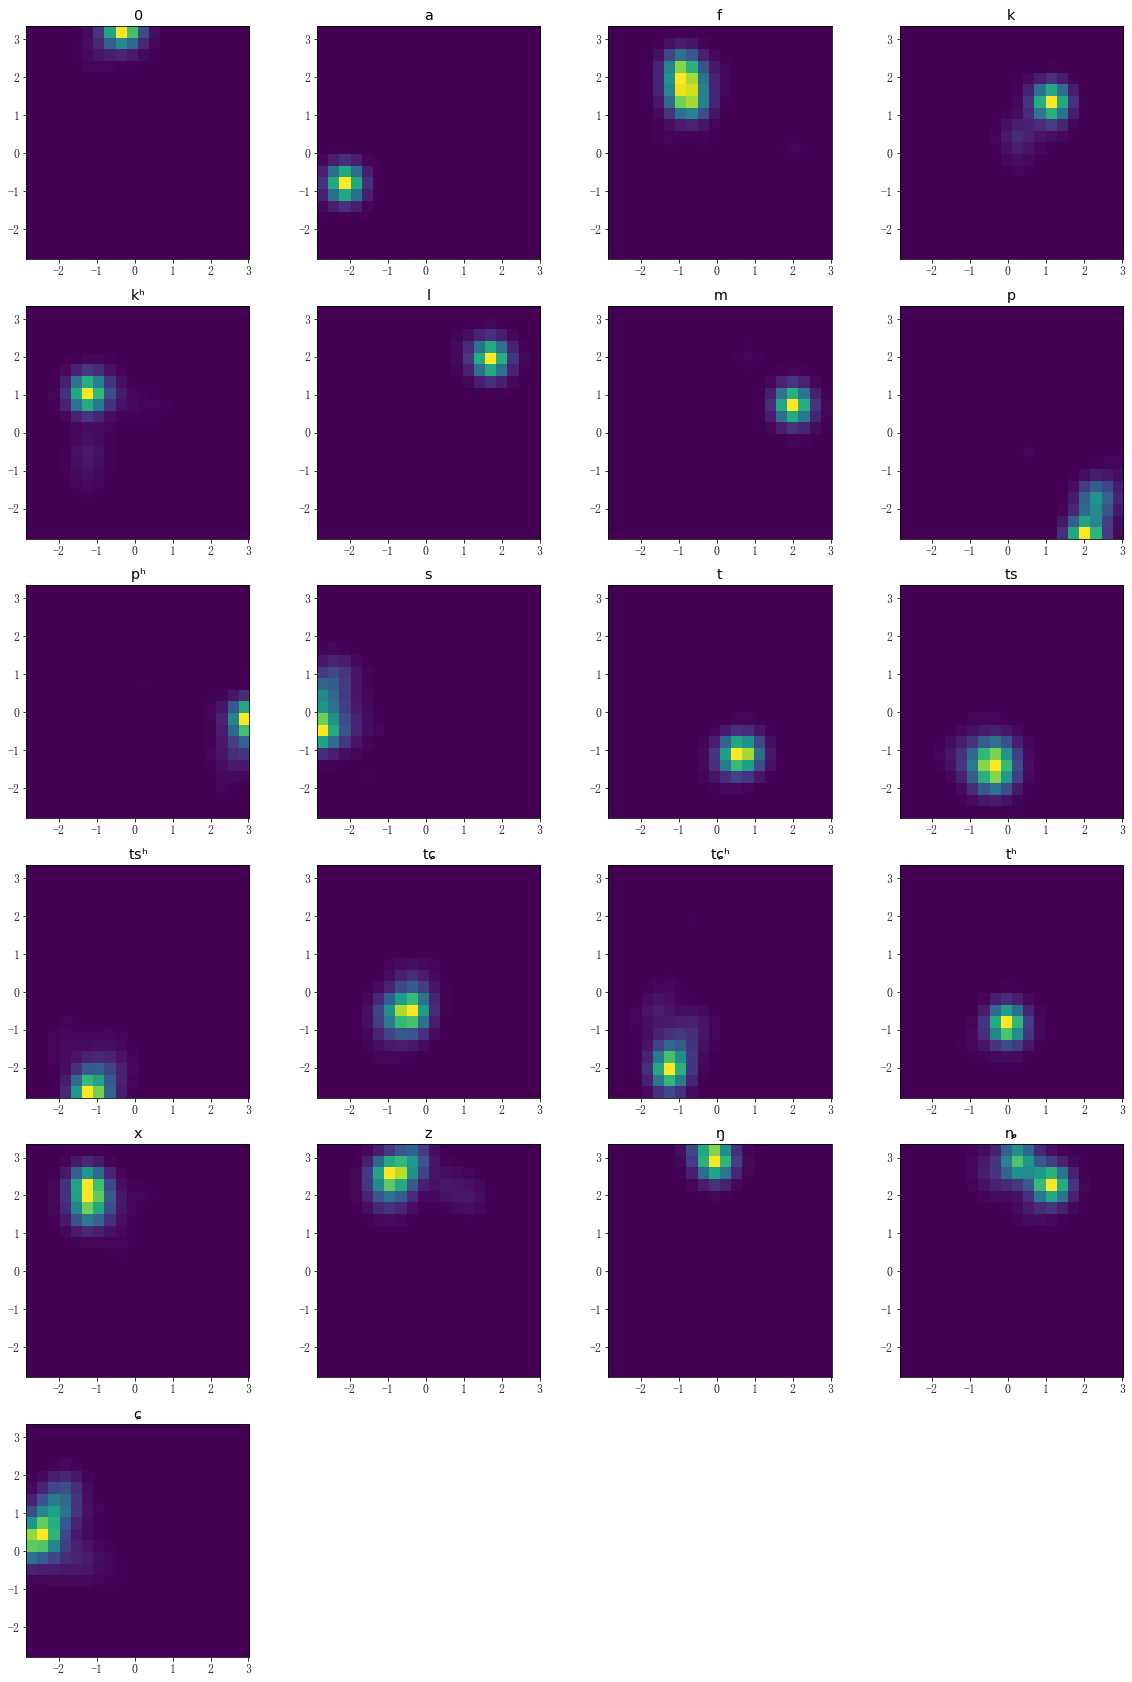

In [14]:
pc = PCA(2).fit_transform(initial_emb)
pc_min = np.min(pc, axis=0)
pc_max = np.max(pc, axis=0)

changsha_initials = data['長沙_聲母'].cat.categories

plt.rcParams['font.size'] = 12
cols = 4
rows = (len(changsha_initials) + cols - 1) // cols
fig = plt.figure(figsize=(20, rows * 5))

h, xbins, ybins = np.histogram2d(pc[:, 0], pc[:, 1], bins=[20, 20])

for i in range(len(changsha_initials)):
    mask = data['長沙_聲母'] == changsha_initials[i]
    ret = np.histogram2d(pc[mask, 0], pc[mask, 1], bins=[xbins, ybins])
    plt.subplot(rows, cols, i + 1)
    plt.imshow(filters.gaussian_filter(ret[0], sigma=1), extent=(xbins[0], xbins[-1], ybins[0], ybins[-1]))
    plt.title(r'$\mathrm{{{}}}$'.format(changsha_initials[i]))
    
fig.show()

<ipython-input-15-3f8f1d404b42>:31: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-15-3f8f1d404b42>:45: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


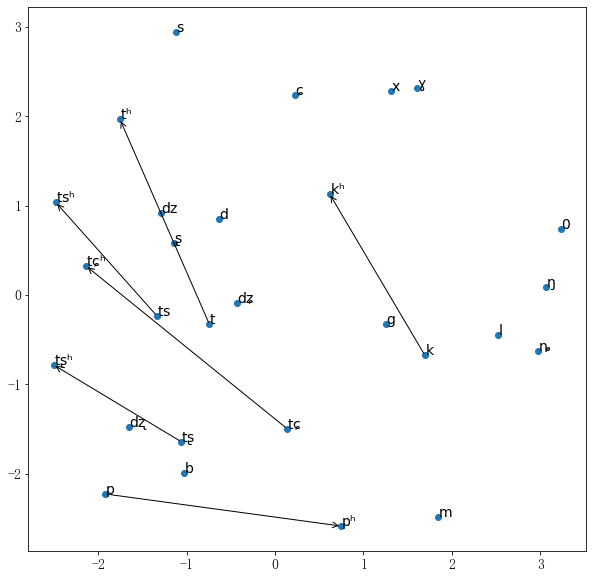

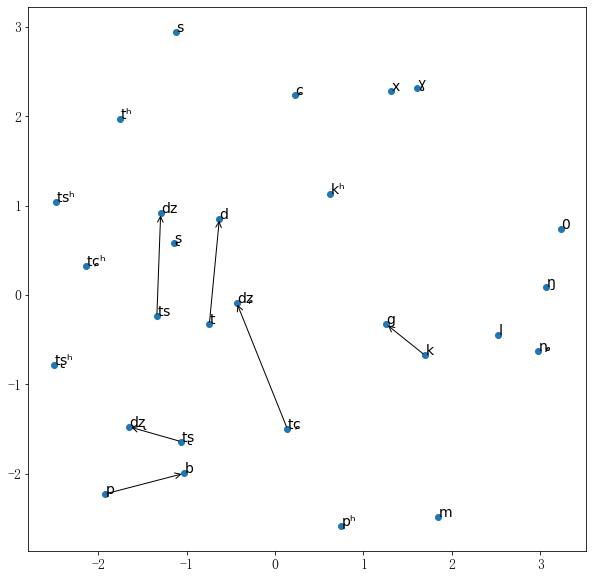

In [15]:
plt.rcParams['font.size'] = 14

col = 1

pc = PCA(2).fit_transform(dae.embedding.numpy()[limits[col]:limits[col + 1]])

fig = plt.figure(figsize=(10, 10))
plt.scatter(pc[:, 0], pc[:, 1])

for i, c in enumerate(categories[col]):
    plt.annotate(r'$\mathrm{{{}}}$'.format(c), xy=(pc[i, 0], pc[i, 1]))
    
dic = dict((c, i) for i, c in enumerate(categories[col]))
for group in (
    ('p', 'pʰ'),
    ('t', 'tʰ'),
    ('k', 'kʰ'),
    ('ts', 'tsʰ'),
    ('tʂ', 'tʂʰ'),
    ('tɕ', 'tɕʰ')
):
    idx = np.asarray([dic[c] for c in group])
    plt.annotate('', xytext=(pc[dic[group[0]], 0], pc[dic[group[0]], 1]), xy=(pc[dic[group[1]], 0], pc[dic[group[1]], 1]), arrowprops={'arrowstyle': '->'})
    
fig = plt.figure(figsize=(10, 10))
plt.scatter(pc[:, 0], pc[:, 1])

for i, c in enumerate(categories[col]):
    plt.annotate(r'$\mathrm{{{}}}$'.format(c), xy=(pc[i, 0], pc[i, 1]))
    
fig.show()
    
dic = dict((c, i) for i, c in enumerate(categories[col]))
for group in (
    ('p', 'b'),
    ('t', 'd'),
    ('k', 'g'),
    ('ts', 'dz'),
    ('tʂ', 'dʐ'),
    ('tɕ', 'dʑ')
):
    idx = np.asarray([dic[c] for c in group])
    plt.annotate('', xytext=(pc[dic[group[0]], 0], pc[dic[group[0]], 1]), xy=(pc[dic[group[1]], 0], pc[dic[group[1]], 1]), arrowprops={'arrowstyle': '->'})
    
fig.show()

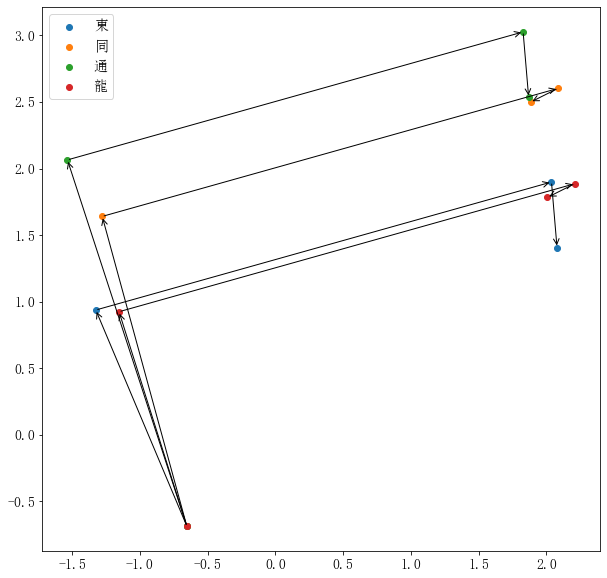

In [16]:
mask = data['字形'].isin(('東', '通', '同', '龍'))

embs = np.stack(
    [np.zeros_like(initial_emb[mask]), initial_emb[mask], final_emb[mask], tone_emb[mask]],
    axis=1
)

points = np.cumsum(embs, axis=1)

pca = PCA(2)
pca.fit(np.reshape(embs, (-1, embs.shape[-1])))

plt.rcParams['font.size'] = 14
fig = plt.figure(figsize=(10, 10))

for i in range(embs.shape[0]):
    pc = pca.transform(np.cumsum(embs[i], axis=0))
    plt.scatter(pc[:, 0], pc[:, 1], label=data[mask]['字形'].iloc[i])
    for j in range(pc.shape[0] - 1):
        plt.annotate('', xytext=(pc[j, 0], pc[j, 1]), xy=(pc[j + 1, 0], pc[j + 1, 1]), arrowprops={'arrowstyle': '->'})
    
plt.legend()

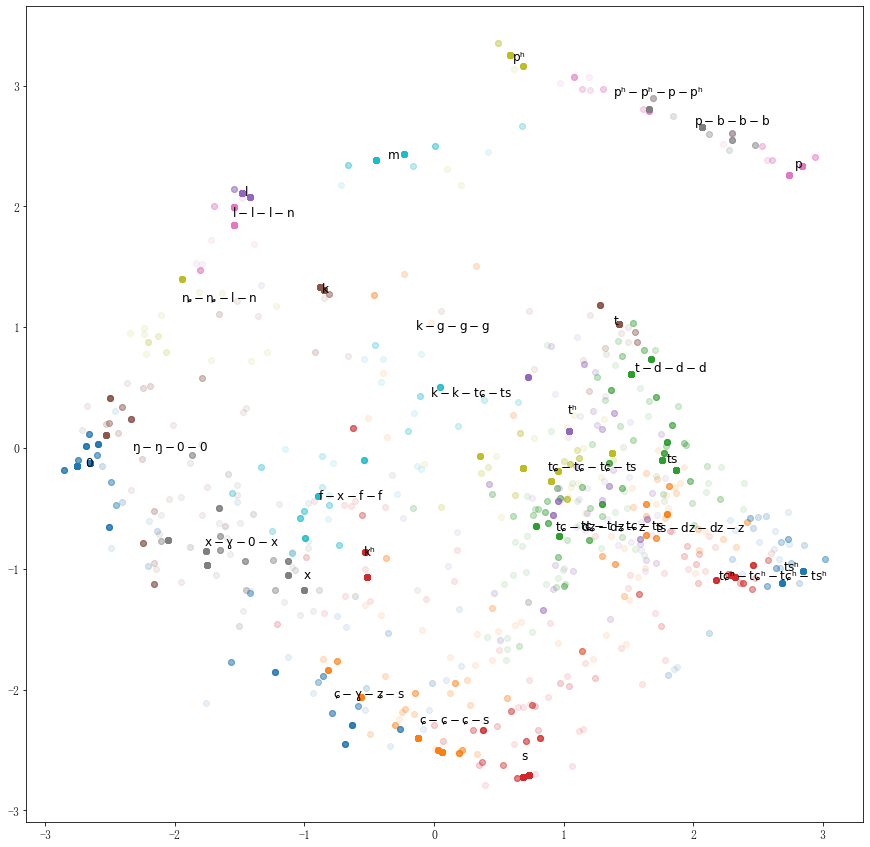

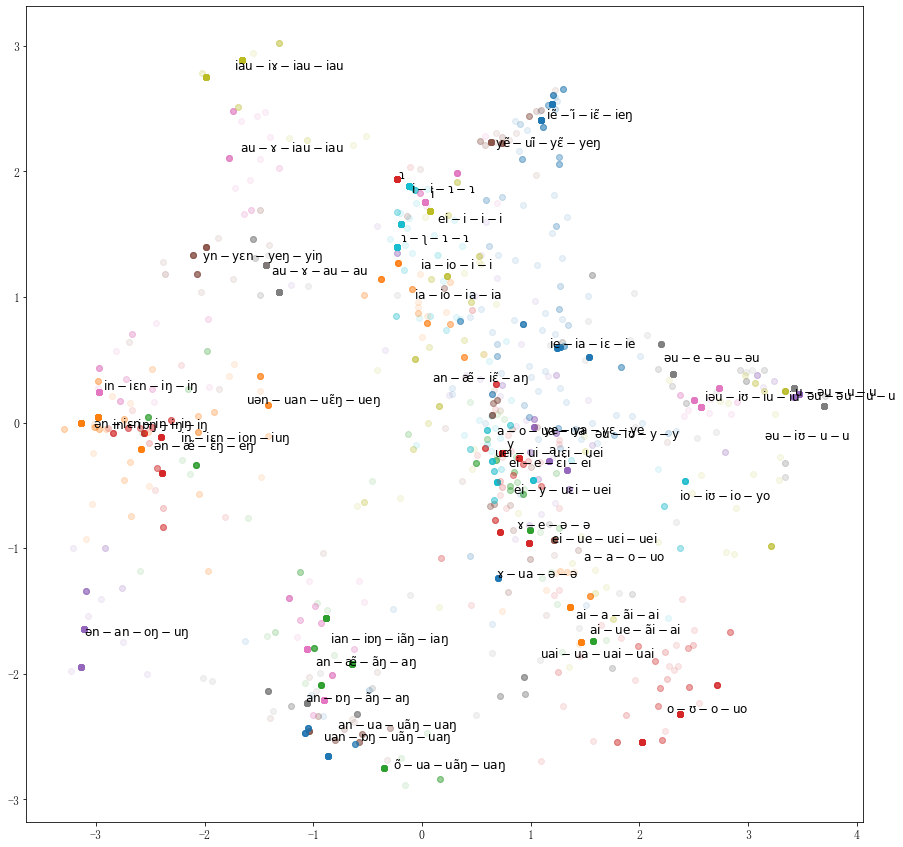

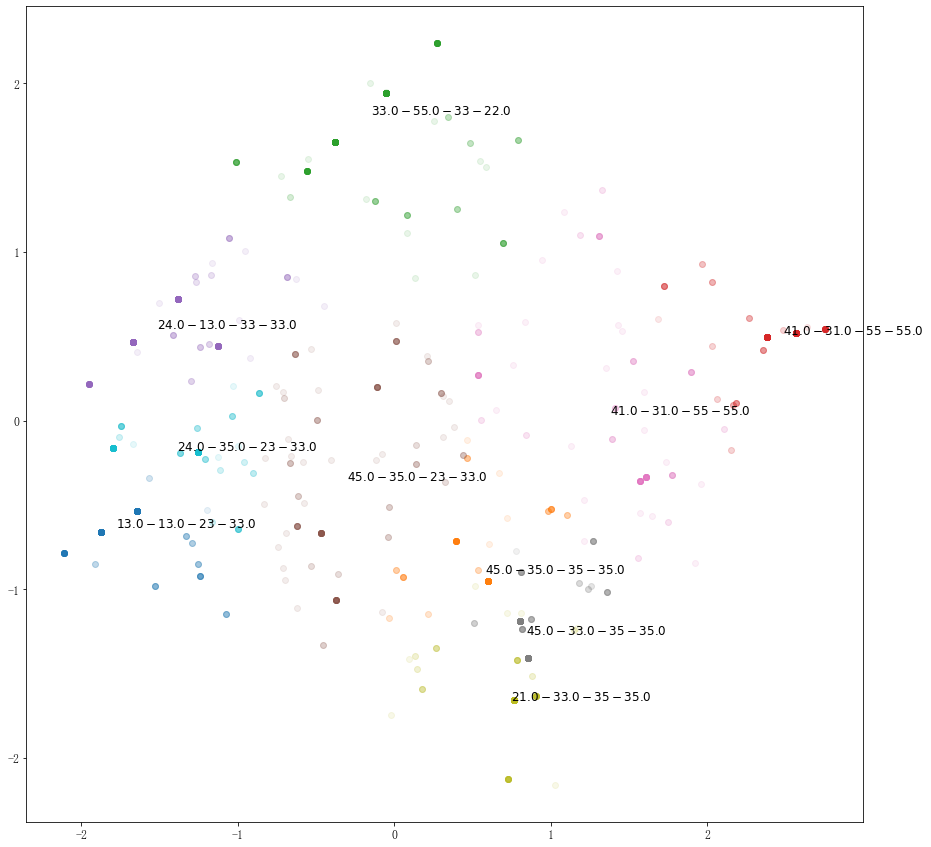

In [17]:
plt.rcParams['font.size'] = 12

for cols, emb, clusters in ((initials, initial_emb, 30), (finals, final_emb, 50), (tones, tone_emb, 10)):
    pca = PCA(2)
    pc = pca.fit_transform(emb)
    km = KMeans(n_clusters=clusters)
    km.fit(emb)
    center_pc = pca.transform(km.cluster_centers_)

    fit = plt.figure(figsize=(15, 15))
    for i in range(km.cluster_centers_.shape[0]):
        labels = data[km.labels_ == i][cols].mode().iloc[0]
        labels = labels[labels.notna()]
        if len(set(labels)) == 1:
            label = str(labels.iloc[0])
        else:
            label = '-'.join(str(l) for l in labels)
        plt.scatter(pc[km.labels_ == i, 0], pc[km.labels_ == i, 1], alpha=0.1)
        plt.annotate(r'$\mathrm{{{}}}$'.format(label), xy=(center_pc[i, 0], center_pc[i, 1]))

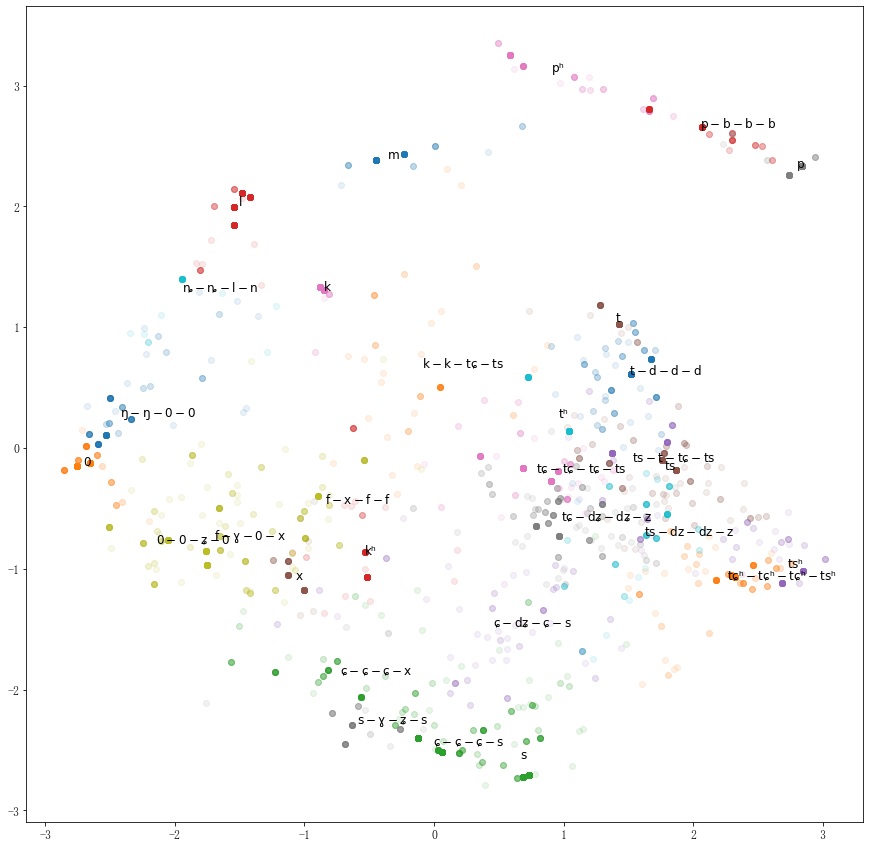

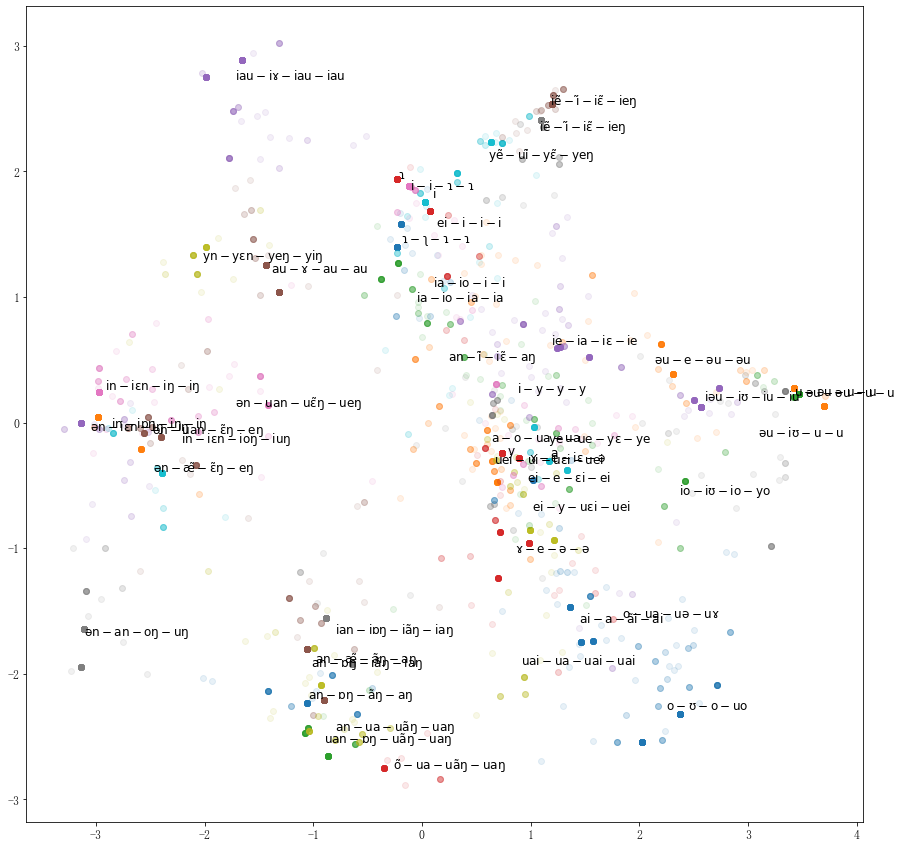

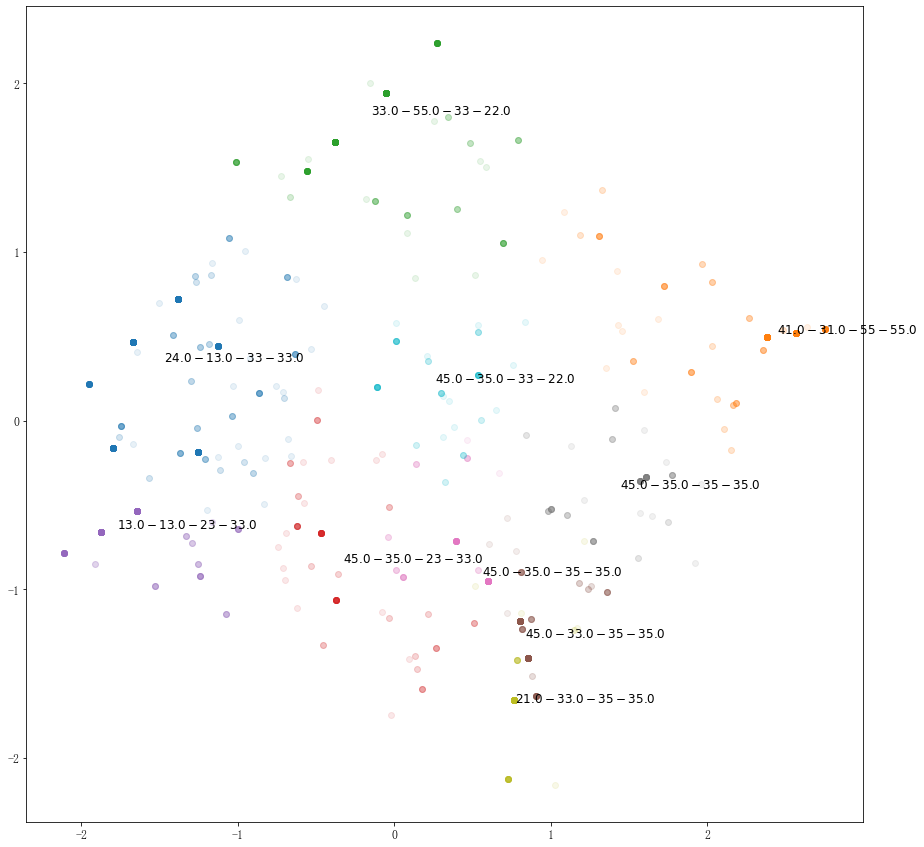

In [18]:
plt.rcParams['font.size'] = 12

for columns, emb, clusters in ((initials, initial_emb, 30), (finals, final_emb, 50), (tones, tone_emb, 10)):
    pca = PCA(2)
    pc = pca.fit_transform(emb)
    ac = AgglomerativeClustering(n_clusters=clusters)
    ac.fit(emb)

    fit = plt.figure(figsize=(15, 15))
    for i in range(ac.n_clusters_):
        labels = data[ac.labels_ == i][columns].mode().iloc[0]
        labels = labels[labels.notna()]
        if len(set(labels)) == 1:
            label = str(labels.iloc[0])
        else:
            label = '-'.join(str(l) for l in labels)
        plt.scatter(pc[ac.labels_ == i, 0], pc[ac.labels_ == i, 1], alpha=0.1)
        plt.annotate(r'$\mathrm{{{}}}$'.format(label), xy=(np.mean(pc[ac.labels_ == i], axis=0)[0], np.mean(pc[ac.labels_ == i], axis=0)[1]))